# Libraries

In [1]:
import kornia as kornia
import numpy as np
import plotly.express as px
import torch
from kornia.color import lab_to_rgb, rgb_to_linear_rgb, rgb_to_xyz, xyz_to_rgb, linear_rgb_to_rgb
from skimage import color
import torchvision.transforms as T
import torchvision.datasets
from skimage.io import imshow
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# For plotting
import numpy as np
import matplotlib.pyplot as plt
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time
from torch.utils.data import DataLoader

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper functions

In [2]:
def rgb_to_lab(image: torch.Tensor) -> torch.Tensor:
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")

    # Convert from sRGB to Linear RGB
    lin_rgb = rgb_to_linear_rgb(image)

    xyz_im: torch.Tensor = rgb_to_xyz(lin_rgb)

    # normalize for D65 white point
    xyz_ref_white = torch.tensor([0.95047, 1.0, 1.08883], device=xyz_im.device, dtype=xyz_im.dtype)[..., :, None, None]
    xyz_normalized = torch.div(xyz_im, xyz_ref_white)

    threshold = 0.008856
    power = torch.pow(xyz_normalized.clamp(min=threshold), 1 / 3.0)
    scale = 7.787 * xyz_normalized + 4.0 / 29.0
    xyz_int = torch.where(xyz_normalized > threshold, power, scale)

    x: torch.Tensor = xyz_int[..., 0, :, :]
    y: torch.Tensor = xyz_int[..., 1, :, :]
    z: torch.Tensor = xyz_int[..., 2, :, :]

    L: torch.Tensor = (116.0 * y) - 16.0
    a: torch.Tensor = 500.0 * (x - y)
    _b: torch.Tensor = 200.0 * (y - z)

    out: torch.Tensor = torch.stack([L, a, _b], dim=-3)

    return out

In [3]:
def lab_to_rgb(L: torch.Tensor, a: torch.Tensor, _b: torch.Tensor, clip: bool = True) -> torch.Tensor:
    # if not isinstance(image, torch.Tensor):
    #     raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")
    #
    # if len(image.shape) < 3 or image.shape[-3] != 3:
    #     raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")

    # L: torch.Tensor = image[..., 0, :, :]
    # a: torch.Tensor = image[..., 1, :, :]
    # _b: torch.Tensor = image[..., 2, :, :]

    fy = (L + 16.0) / 116.0
    fx = (a / 500.0) + fy
    fz = fy - (_b / 200.0)

    # if color data out of range: Z < 0
    fz = fz.clamp(min=0.0)

    fxyz = torch.stack([fx, fy, fz], dim=-3)

    # Convert from Lab to XYZ
    power = torch.pow(fxyz, 3.0)
    scale = (fxyz - 4.0 / 29.0) / 7.787
    xyz = torch.where(fxyz > 0.2068966, power, scale)

    # For D65 white point
    xyz_ref_white = torch.tensor([0.95047, 1.0, 1.08883], device=xyz.device, dtype=xyz.dtype)[..., :, None, None]
    xyz_im = xyz * xyz_ref_white

    rgbs_im: torch.Tensor = xyz_to_rgb(xyz_im)

    # https://github.com/richzhang/colorization-pytorch/blob/66a1cb2e5258f7c8f374f582acc8b1ef99c13c27/util/util.py#L107
    #     rgbs_im = torch.where(rgbs_im < 0, torch.zeros_like(rgbs_im), rgbs_im)

    # Convert from RGB Linear to sRGB
    rgb_im = linear_rgb_to_rgb(rgbs_im)

    # Clip to 0,1 https://www.w3.org/Graphics/Color/srgb
    if clip:
        rgb_im = torch.clamp(rgb_im, min=0.0, max=1.0)

    return rgb_im

In [4]:
class AverageMeter(object):
    '''A handy class from the PyTorch ImageNet tutorial'''

    def __init__(self):
        self.reset()

    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Device Configuration

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_path = 'images/train/'
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # can experiment
    transforms.ToTensor(),  # divide the pixel by 255
])

# Loading the data

In [6]:
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=90, shuffle=True)

# Convert RBG to LAB space

In [58]:
X = []  # array of tensors of  L
y = []  # array of tensors of A and B
LAB = []
for idx, (data, target) in enumerate(train_loader):
    for i in data:
        Lab = rgb_to_lab(i / 255)
        LAB.append(Lab)
        X.append(Lab[0])
        y.append(Lab[1:3])

x = []
for i in X:
    w = np.array(i)
    x.append(torch.tensor(np.array([w])))

x[0].shape
# newInput = []
# for i in x:
#     newX = i
#     newX = newX[None, :]
#     newInput.append(newX)    

torch.Size([1, 256, 256])

# Creating the model

In [84]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(128, 2, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(1),
            nn.ReLU(),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
#             nn.Upsample(scale_factor=2)
        )          

    def forward(self, x):
        x = self.layer(x)
#         y = self.layer(x)
        return x
#         return torch.cat((x, y), 0)

In [85]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.layer = torch.nn.Linear(256, 256)

#     def forward(self, x):
#         x = self.layer(x)
#         return x

# Initialize the network

In [86]:
model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()
losses = AverageMeter()

In [91]:
predictions = []

for epoch in range(1):
    tempPred = []
    for i in range(len(x)):
        # forward
        scores = model(x[i])
        tempPred.append(scores)
        loss = loss_func(scores, y[i])
        losses.update(loss.item(), x[i].size(0))
        # backward
        optimizer.zero_grad()
#         hidden.detach_()
#         hidden = hidden.detach()
        loss.backward()
#         loss.backward(retain_graph=True)
        # gradient descent step
        optimizer.step()

        if i % 25 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                epoch, i, len(train_loader), loss=losses))

    predictions.append(tempPred)

RuntimeError: Can't detach views in-place. Use detach() instead. If you are using DistributedDataParallel (DDP) for training, and gradient_as_bucket_view is set as True, gradients are views of DDP buckets, and hence detach_() cannot be called on these gradients. To fix this error, please refer to the Optimizer.zero_grad() function in torch/optim/optimizer.py as the solution.

# showing the prediction of picture 71

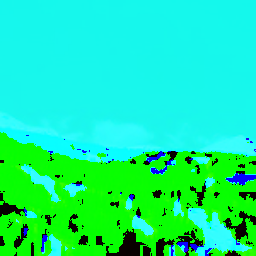

In [63]:
firstAB = predictions[0]
LAB2 = LAB
lab71 = LAB2[71]
transform = T.ToPILImage()
img = transform(lab71)
img

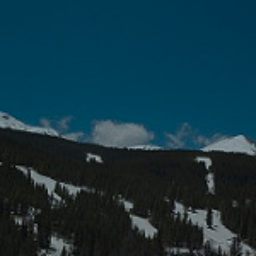

In [64]:
output = lab_to_rgb(lab71[0]*255, lab71[1]*255, lab71[2]*255)
transform = T.ToPILImage()
img1 = transform(output)
img1

torch.Size([1, 256, 256])
torch.Size([256, 256])


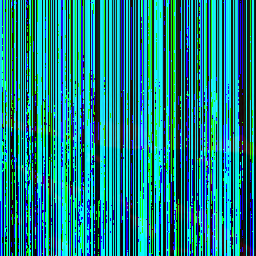

In [65]:
firstAB = predictions[0]
LAB2 = LAB
lab71 = LAB2[71]
print(firstAB[0].shape)
print(lab71[1].shape)
lab71[1] = firstAB[0]
lab71[2] = firstAB[1]
transform = T.ToPILImage()
img = transform(lab71)
img

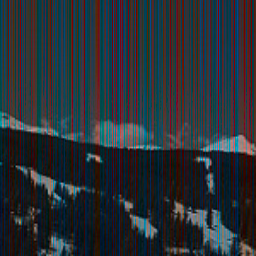

In [66]:
output = lab_to_rgb(lab71[0]*255, lab71[1]*255, lab71[2]*255)
transform = T.ToPILImage()
img1 = transform(output)
img1

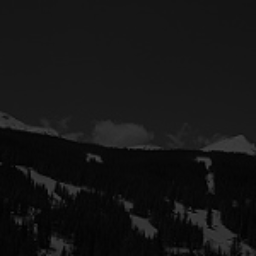

In [67]:
img1 = transform(x[71])
img1